In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from helper import *
import joblib
from collections import Counter

# sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC
from scipy.stats import loguniform

# boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# model evaluation
from yellowbrick.model_selection import LearningCurve

# display
from IPython.display import display as dp
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style("darkgrid")

🎯 Modeling Goal: \
Detect as many stroke patients as possible without bloating FP rate too much, 

>FN is more important than FP

As the classes are highly imbalanced, 
>Candidate scoring metrics: 
> - roc_auc
> - pr_auc
> - f1(macro)
> - recall

In [2]:
df = joblib.load("./stroke_modeling.csv")

# convert object columns types to category
obj_columns_to_convert = [
    "work_type",
    "smoking_status",
]
int_columns_to_convert = df.select_dtypes("int").columns.tolist()
df[obj_columns_to_convert] = df[obj_columns_to_convert].astype("category")
df[int_columns_to_convert] = df[int_columns_to_convert].astype("float")

📊 Train test split

In [3]:
target = df.stroke.values
features = df.drop(columns=["stroke"])

X_train, X_test, y_train, y_test = train_test_split(
    features, target, stratify=target, test_size=0.2, random_state=1
)

# print train and test class df
class_df = pd.DataFrame(
    {"train": Counter(y_train).values(), "test": Counter(y_test).values()},
    index=["class_0", "class_1"],
).T
bprint("Train and Test Class Proportion")
class_prop_df = class_df.apply(lambda i: round(i / sum(i), 3), axis=1)

class_df["class_0_prop"] = class_prop_df.class_0
class_df["class_1_prop"] = class_prop_df.class_1

dp(
    class_df.style.apply(
        lambda i: [
            "background-color: rosybrown" if id > 1 else "background-color: "
            for id, _ in enumerate(i)
        ],
        axis=1,
    )
)


Train and Test Class Proportion


,class_0,class_1,class_0_prop,class_1_prop
train,3888,199,0.951000,0.049000
test,972,50,0.951000,0.049000


📊 Stratify cv splits for nested cv

In [4]:
tuning_cv = StratifiedKFold(
    n_splits=4,
    shuffle=True,
    random_state=1,
)
model_selection_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=6)

📊 Build preprocessing transformers for categorial and numerical variables.

In [5]:
# one hot encoder
onehot_encoder = OneHotEncoder()
# test out different scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

num_cols = [
    "age",
    "avg_glucose_level",
    "bmi",
    "heart_diseases_history",
    "age_bmi_percentile",
]
cat_cols = df.drop(columns=["stroke"]).select_dtypes(["category"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("numerical", standard_scaler, num_cols),
        ("categorial", onehot_encoder, cat_cols),
    ],
    remainder="passthrough",
)
# save prerpocessed feature column names
prepreocessed_cols = preprocess.fit(X_train).get_feature_names_out()

dp(preprocess)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['age', 'avg_glucose_level', 'bmi',
                                  'heart_diseases_history',
                                  'age_bmi_percentile']),
                                ('categorial', OneHotEncoder(),
                                 Index(['work_type', 'smoking_status'], dtype='object'))])

📊 Metrics selection

We need to decide on the scoring metrics for RandomizedSearch. 

In [6]:
# model
pipe = Pipeline(
    steps=[
        ("preprocessing", preprocess),
        ("classifier", LogisticRegression(class_weight="balanced")),
    ]
)
# random_state should be set for logistregression

# params
fixed_params = {
    "preprocessing__numerical": [standard_scaler, minmax_scaler, robust_scaler],
    "classifier__C": loguniform(0.001, 10),
}

logit_params = [
    {
        **fixed_params,
        "classifier__solver": ["liblinear"],
        "classifier__penalty": ["l1", "l2"],
    },
    {
        **fixed_params,
        "classifier__solver": ["lbfgs"],
        "classifier__penalty": ["l2"],
    },
    {
        "preprocessing__numerical": [standard_scaler, minmax_scaler, robust_scaler],
        "classifier__solver": ["lbfgs"],
        "classifier__penalty": [None],
    },
]


# randomized search using different metrics

# f1
search_logit_f1 = RandomizedSearchCV(
    pipe,
    param_distributions=logit_params,
    cv=tuning_cv,
    n_iter=200,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=3,
)

# pr_auc
search_logit_pr_auc = RandomizedSearchCV(
    pipe,
    param_distributions=logit_params,
    cv=tuning_cv,
    n_iter=200,
    scoring="average_precision",
    n_jobs=-1,
    random_state=3,
)

# roc_auc
search_logit_roc_auc = RandomizedSearchCV(
    pipe,
    param_distributions=logit_params,
    cv=tuning_cv,
    n_iter=200,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=3,
)

# recall
search_logit_recall = RandomizedSearchCV(
    pipe,
    param_distributions=logit_params,
    cv=tuning_cv,
    n_iter=200,
    scoring="recall",
    # scoring=["recall", 'roc_auc', ''],
    n_jobs=-1,
    random_state=3,
)

# fit models
res_logit_f1 = search_logit_f1.fit(X_train, y_train)
res_logit_pr_auc = search_logit_pr_auc.fit(X_train, y_train)
res_logit_roc_auc = search_logit_roc_auc.fit(X_train, y_train)
res_logit_recall = search_logit_recall.fit(X_train, y_train)

# get best estimators
best_logit_f1 = res_logit_f1.best_estimator_
best_logit_pr_auc = res_logit_pr_auc.best_estimator_
best_logit_roc_auc = res_logit_roc_auc.best_estimator_
best_logit_recall = res_logit_recall.best_estimator_

In [7]:
# show top 4 models mean and std scores for different scoring metrics
bprint("Top5 models scores")

bprint("f1")
show_rank_scores(res_logit_f1)

bprint("pr_auc")
show_rank_scores(res_logit_pr_auc)

bprint("roc_auc")
show_rank_scores(res_logit_roc_auc)

bprint("recall")
show_rank_scores(res_logit_recall)


Top5 models scores

f1


,rank_test_score,mean_test_score,std_test_score
167,1,0.536928,0.004169
145,2,0.536926,0.004040
111,3,0.535283,0.004679
62,4,0.534051,0.002972
64,5,0.533776,0.003453



pr_auc


,rank_test_score,mean_test_score,std_test_score
29,1,0.204842,0.039398
129,2,0.204830,0.039354
161,3,0.204273,0.038280
116,4,0.203991,0.038982
171,5,0.203341,0.037838



roc_auc


,rank_test_score,mean_test_score,std_test_score
48,1,0.833431,0.017868
20,2,0.833425,0.017497
24,3,0.833368,0.017674
72,4,0.833325,0.017215
47,5,0.832791,0.018326



recall


,rank_test_score,mean_test_score,std_test_score
183,1,0.964898,0.029529
14,1,0.964898,0.029529
124,1,0.964898,0.029529
197,4,0.949796,0.022272
182,4,0.949796,0.022272


📝 Best models for different scoring metrics

The std of the hyperparameter tuning cv are not very different for the top 5 model \
of all 5 metrics, we can just use the best ones.

📊 Use cross_validation and confusion matrix to compare the prediction \
of the 4 metrics.


CV metrics of models selected using 4 different scoring methods (max scores highlighted)



score_mean


,roc_auc,f1,pr_auc,recall,accuracy,precision
Models,,,,,,
F1,0.827465,0.227971,0.191349,0.784231,0.741614,0.133441
PR_AUC,0.830582,0.217197,0.205150,0.779103,0.727426,0.126227
ROC_AUC,0.835365,0.207635,0.192384,0.834231,0.690232,0.118610
RECALL,0.830067,0.168064,0.177161,0.954872,0.539264,0.092154



Learning Curve for LOGIT model using ROC_AUC for scoring:


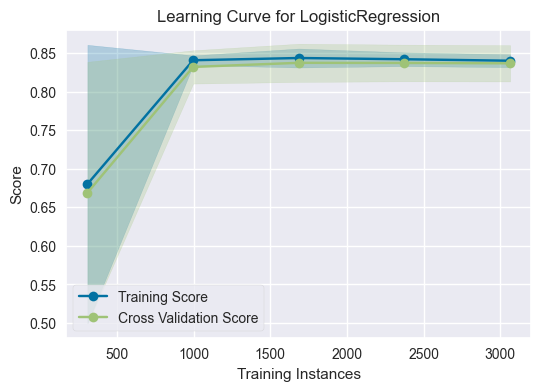

In [8]:
bprint(
    "CV metrics of models selected using 4 different scoring methods (max scores highlighted)"
)
comparison_cv_mean = (
    cv_scores(
        X_train,
        y_train,
        [best_logit_f1, best_logit_pr_auc, best_logit_roc_auc, best_logit_recall],
        ["F1", "PR_AUC", "ROC_AUC", "RECALL"],
    )["mean"]
    .iloc[2:, :]
    .T.rename_axis("Models")
)

comparison_cv_std = (
    cv_scores(
        X_train,
        y_train,
        [best_logit_f1, best_logit_pr_auc, best_logit_roc_auc, best_logit_recall],
        ["F1", "PR_AUC", "ROC_AUC", "RECALL"],
    )["std"]
    .iloc[2:, :]
    .T.rename_axis("Models")
)
bprint("score_mean")
dp(comparison_cv_mean.style.highlight_max())

# learning curve
bprint("Learning Curve for LOGIT model using ROC_AUC for scoring:")
fig_size(6, 4)
visualizer = LearningCurve(
    best_logit_roc_auc, cv=model_selection_cv, scoring="roc_auc", n_jobs=-1
)

visualizer.fit(X_train, y_train)

visualizer.show()
plt.show()

📝 logistic regression learning curve (roc_auc scoring model)

The model has high variance and bias when the training instances is below 1000. \
When there's more than 1000 training instances, the model stabilizes. 

The two curves are almost overlapping with eachother afterwards. 
> Only small sample size (1000~) is required to train a performant logit model for this \
> dataset. 


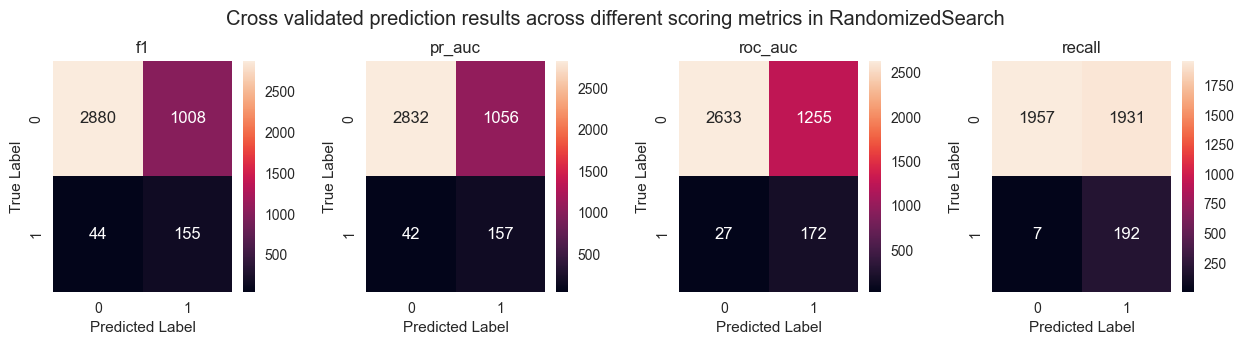

In [9]:
cv_pred_logit_f1 = cross_val_predict(
    best_logit_f1,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)


cv_pred_logit_pr_auc = cross_val_predict(
    best_logit_pr_auc,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)

cv_pred_logit_roc_auc = cross_val_predict(
    best_logit_roc_auc,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)

cv_pred_logit_recall = cross_val_predict(
    best_logit_recall,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)

fig_size(15, 3)
plt.subplot(1, 4, 1)
plot_confusion(cv_pred_logit_f1, y_train, "f1")
plt.subplot(1, 4, 2)
plot_confusion(cv_pred_logit_pr_auc, y_train, "pr_auc")
plt.subplot(1, 4, 3)
plot_confusion(cv_pred_logit_roc_auc, y_train, "roc_auc")
plt.subplot(1, 4, 4)
plot_confusion(cv_pred_logit_recall, y_train, "recall")

plt.subplots_adjust(wspace=0.4)
plt.suptitle(
    "Cross validated prediction results across different scoring metrics in RandomizedSearch",
    y=1.05,
)

plt.show()

📝 Scoring metrics selection for further models

`roc_auc` is the most suitable metrics for our goal of detecting stroke data. \
Although we can capture more stroke instances using recall as scoring metrics , \
the false positive rate is almost 50%, this is not ideal.

> For further models, `roc_auc` would be used as the scoring metrics.

In [10]:
best_logit = best_logit_roc_auc

#### Try out more models

📊 SVC


best params


,param_value
classifier__C,0.067082
classifier__gamma,0.034014
classifier__kernel,rbf
preprocessing__numerical,RobustScaler()



Top5 models scores


,rank_test_score,mean_test_score,std_test_score
6,1,0.827518,0.015648
17,2,0.827326,0.011436
0,3,0.822625,0.003758
9,4,0.818028,0.003244
12,5,0.813091,0.003540



Learning Curve for best SVC estimator:


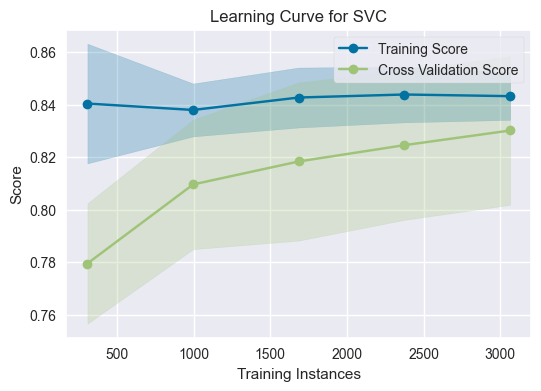

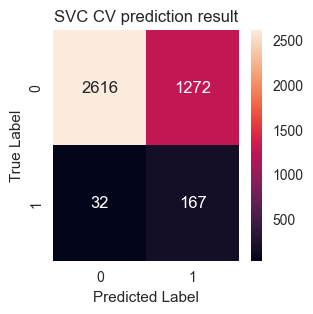

In [11]:
# model
pipe = Pipeline(
    steps=[
        ("preprocessing", preprocess),
        # slower if probability = True, 5 times slower due to cv
        ("classifier", SVC(class_weight="balanced", random_state=0, probability=True)),
    ]
)

# params
fixed_params = {
    "preprocessing__numerical": [standard_scaler, minmax_scaler, robust_scaler],
    "classifier__C": loguniform(0.001, 0.1),
}

svc_params = {
    **fixed_params,
    "classifier__kernel": ["rbf"],
    "classifier__gamma": loguniform(0.001, 0.1),
}

# randomized search for hyperparamter tuning
search_svc_roc_auc = RandomizedSearchCV(
    pipe,
    param_distributions=svc_params,
    cv=tuning_cv,
    n_iter=20,
    n_jobs=-1,
    random_state=3,
    scoring="roc_auc",
)

# fit models
res_svc_roc_auc = search_svc_roc_auc.fit(X_train, y_train)

# get best estimators
best_svc = res_svc_roc_auc.best_estimator_

# best params
bprint("best params")
dp(pd.DataFrame(pd.Series(res_svc_roc_auc.best_params_), columns=["param_value"]))

# list top5 estimators
bprint("Top5 models scores")
dp(
    pd.DataFrame(res_svc_roc_auc.cv_results_)
    .sort_values(by="rank_test_score")[
        ["rank_test_score", "mean_test_score", "std_test_score"]
    ]
    .head()
    .style.apply(mark_df_color, id=0, axis=0)
)
# learning curve of the best estimator
bprint("Learning Curve for best SVC estimator:")

fig_size(6, 4)
visualizer = LearningCurve(
    best_svc, cv=model_selection_cv, scoring="roc_auc", n_jobs=-1
)

visualizer.fit(X_train, y_train)

visualizer.show()
plt.show()

# nested cross validation prediction
cv_pred_svc_roc_auc = cross_val_predict(
    best_svc,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)

# confusion matrix
fig_size(3, 3)
plot_confusion(cv_pred_svc_roc_auc, y_train, "SVC CV prediction result")

📝 SVC model

Learning curve: 
- the training and cv curves both have `high variation`, the variation even \
increases with more training instances. 

- I tried to apply stronger regularization for the model, but the result did \
not change much. 

- As the training and cv curve are coming closer with the increase of training \
instances, `obtaining more data could potentially improve the SVC prediction`. 

Prediction: 
- The prediction result of SVC model is worse than logit model in fp and fn rate.

📊 XGBoost


best params


,param_value
colsample_bytree,0.700000
eta,0.015950
gamma,0.191751
max_depth,2.000000
n_estimators,52.000000
reg_alpha,0.589431
reg_lambda,0.604690
subsample,0.800000



Top5 models scores


,rank_test_score,mean_test_score,std_test_score
115,1,0.830480,0.015098
18,2,0.829342,0.019717
33,3,0.827452,0.014028
100,4,0.826620,0.020693
181,5,0.826274,0.009200



Learning Curve for best XGBoost estimator:


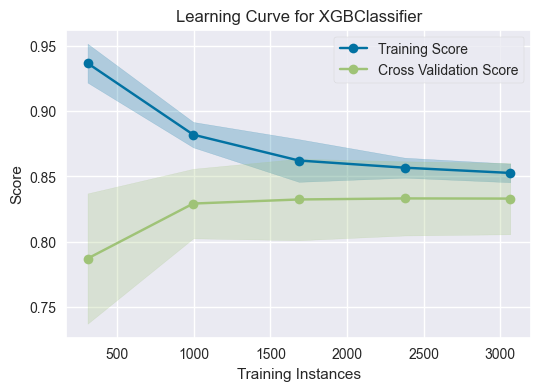

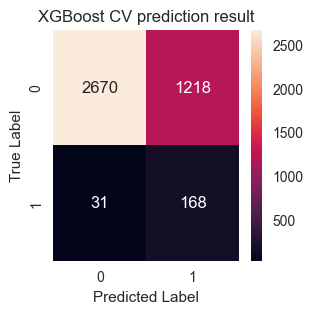

In [12]:
# get class weight
class_weight_ls = list(Counter(y_train).values())
class_weight_balance_scale = class_weight_ls[0] / class_weight_ls[1]

# model
model = XGBClassifier(
    scale_pos_weight=class_weight_balance_scale,
    seed=0,
    objective="binary:logistic",
    enable_categorical=True,
)

# params
xgb_params = {
    "max_depth": range(1, 10),
    "gamma": loguniform(0.01, 1),
    "eta": loguniform(0.01, 0.04),
    "reg_lambda": loguniform(0.001, 10),
    "subsample": np.arange(0.1, 1, 0.1),
    "n_estimators": range(10, 300),
    "colsample_bytree": np.arange(0.1, 1, 0.1),
    "reg_alpha": loguniform(0.001, 10),
}

# randomized search for hyperparamter tuning
search_xgb_roc_auc = RandomizedSearchCV(
    model,
    param_distributions=xgb_params,
    cv=tuning_cv,
    n_iter=200,
    n_jobs=-1,
    random_state=3,
    scoring="roc_auc",
)

# fit models
res_xgb_roc_auc = search_xgb_roc_auc.fit(X_train, y_train)

# get best estimators
best_xgb = res_xgb_roc_auc.best_estimator_

# best params
bprint("best params")
dp(pd.DataFrame(pd.Series(res_xgb_roc_auc.best_params_), columns=["param_value"]))

# list top5 estimators
bprint("Top5 models scores")
dp(
    pd.DataFrame(res_xgb_roc_auc.cv_results_)
    .sort_values(by="rank_test_score")[
        ["rank_test_score", "mean_test_score", "std_test_score"]
    ]
    .head()
    .style.apply(mark_df_color, id=0, axis=0)
)

# learning curve of the best estimator
bprint("Learning Curve for best XGBoost estimator:")

fig_size(6, 4)
visualizer = LearningCurve(
    best_xgb, cv=model_selection_cv, scoring="roc_auc", n_jobs=-1
)

visualizer.fit(X_train, y_train)

visualizer.show()
plt.show()

# nested cross validation prediction
cv_pred_xgb_roc_auc = cross_val_predict(
    best_xgb,
    X_train,
    y_train,
    cv=model_selection_cv,
    n_jobs=-1,
)

# confusion matrix
fig_size(3, 3)
plot_confusion(cv_pred_xgb_roc_auc, y_train, "XGBoost CV prediction result")

📝 XGB model

Learning curve: 

- the training data is overfitting with small training instances \
(initial score > 0.9), with the increase of training data, it stabilizes.

- As the distance between the training and cv curve are consistent and stays \
parallel when the training instances > 2300, collecting more data might not \
improve the prediction.

Prediction: 

- The prediction result of XGB model is similar to SVC in fn rate, and better in \
fp rate.

📊 LGBM


best params


,param_value
bagging_fraction,0.500000
bagging_freq,1.000000
feature_fraction,0.400000
lambda_l1,0.001617
learning_rate,0.050000
max_depth,2.000000
min_data_in_leaf,200.000000
num_leaves,48.000000



Top5 models scores


,rank_test_score,mean_test_score,std_test_score
22,1,0.828669,0.017863
42,2,0.826532,0.019747
11,3,0.825519,0.011426
14,4,0.825477,0.015211
33,5,0.823669,0.018477



Learning Curve for best LGBM estimator:


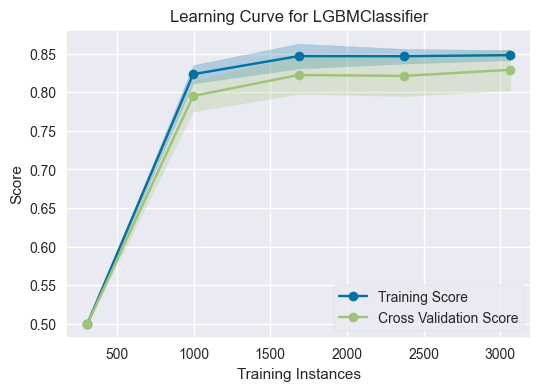

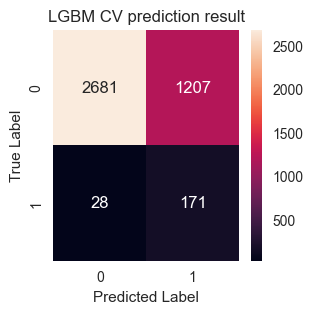

In [13]:
# model
model = LGBMClassifier(
    objective="binary", is_unbalance=True, seed=0, force_row_wise=True, verbose=-1
)

# best_model ()
very_best_lgbm = LGBMClassifier(
    objective="binary",
    is_unbalance=True,
    seed=0,
    force_row_wise=True,
    verbose=-1,
    bagging_fraction=0.4,
    bagging_freq=1,
    feature_fraction=0.6,
    lambda_l1=0.003815,
    learning_rate=0.05,
    max_depth=1,
    min_data_in_leaf=190,
    num_leaves=53,
)

very_best_lgbm.fit(X_train, y_train)

# params
lgbm_params = {
    "lambda_l1": loguniform(0.001, 0.005),
    "feature_fraction": np.arange(0.4, 0.8, 0.1),
    "bagging_fraction": np.arange(0.3, 0.6, 0.1),
    "bagging_freq": np.arange(1, 3),
    "num_leaves": np.arange(48, 55),
    "max_depth": np.arange(1, 3),
    "learning_rate": [0.05, 0.1],
    "min_data_in_leaf": np.arange(160, 210, 10),
}

# randomized search for hyperparamter tuning
search_lgbm_roc_auc = RandomizedSearchCV(
    model,
    param_distributions=lgbm_params,
    cv=tuning_cv,
    n_iter=50,
    n_jobs=-1,
    random_state=3,
    scoring="roc_auc",
)

# fit models
res_lgbm_roc_auc = search_lgbm_roc_auc.fit(X_train, y_train)
# get best estimators
best_lgbm = res_lgbm_roc_auc.best_estimator_

# best params
bprint("best params")
dp(pd.DataFrame(pd.Series(res_lgbm_roc_auc.best_params_),
   columns=["param_value"]))

# list estimators
bprint("Top5 models scores")
dp(
    pd.DataFrame(res_lgbm_roc_auc.cv_results_)
    .sort_values(by="rank_test_score")[
        ["rank_test_score", "mean_test_score", "std_test_score"]
    ]
    .head()
    .style.apply(mark_df_color, id=0, axis=0)
)

# learning curve of the best estimator
bprint("Learning Curve for best LGBM estimator:")

fig_size(6, 4)
visualizer = LearningCurve(
    very_best_lgbm, cv=model_selection_cv, scoring="roc_auc", n_jobs=-1
)

visualizer.fit(X_train, y_train)

visualizer.show()
plt.show()

# nested cross validation prediction
cv_pred_lgbm_roc_auc = cross_val_predict(
    very_best_lgbm, X_train, y_train, cv=model_selection_cv, n_jobs=-1
)

# confusion matrix
fig_size(3, 3)
plot_confusion(cv_pred_lgbm_roc_auc, y_train, "LGBM CV prediction result")

📝 LGBM

Learning curve

- The learning curve shows that the trained LGBM model has small bias and small \
variance, both curves plateau and stabilizes at 1700~ training instances and \
they always stay very close together.


Prediction: 

- Looking at the cv prediction confusion matrix, LGBM has by far the `lowest` \
`FP rate`, and `second lowest FN rate` (only 1 sample worse than logit). 


#### Features evaluation and Error analysis

📊 Ensemble models feature importance with shap

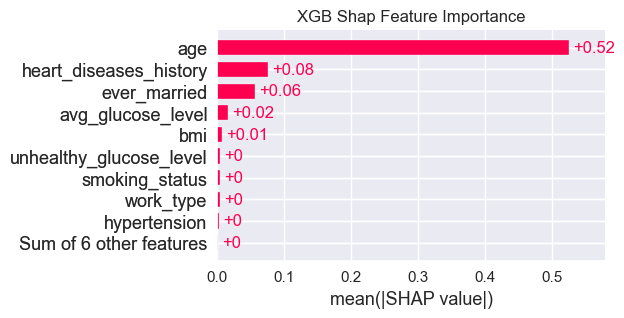

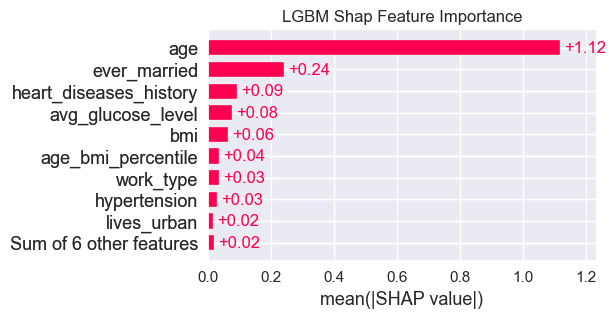

In [14]:
plot_tree_shap_feature_importance(best_xgb, "XGB", X_train)
plot_tree_shap_feature_importance(very_best_lgbm, "LGBM", X_train)

📝 Compare feature importance of the ensemble models

XGB: 
- only 4 features have importance
> This might be the reason why XGB overfits in the beginning of the learning \
curve as it just memorized the limited feature combinations.
- age is the most important feature

LGBM:
- almost all features are used for classification
- age is the most important feature

📊 Error analysis

LGBM is used for error analysis because it is the most promising model with: 

- good pr_auc score
- low fn rate
- low fp rate
- low variance between cv folds

Dive deeper into its errors.

- Mark the errors (fn, fp)

In [15]:
pred = very_best_lgbm.predict(X_train)
pred_df = X_train.copy()

pred_df["y_true"] = y_train
pred_df["y_pred"] = pred

pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"id": "oid"})
pred_df = pred_df.drop(columns=["oid"])

is_fn = np.where(((pred_df.y_true == 1) & (pred_df.y_pred == 0)), 1, 0)
is_fp = np.where(((pred_df.y_true == 0) & (pred_df.y_pred == 1)), 1, 0)
is_tn = np.where(((pred_df.y_true == 0) & (pred_df.y_pred == 0)), 1, 0)
is_tp = np.where(((pred_df.y_true == 1) & (pred_df.y_pred == 1)), 1, 0)

pred_df["fn"] = is_fn
pred_df["fp"] = is_fp
pred_df["tn"] = is_tn
pred_df["tp"] = is_tp


# false negatives for the prediction
fn_id = pred_df.loc[pred_df.fn == 1].index.tolist()
fn_df = pred_df.loc[fn_id, pred_df.columns[:-6]]
# false positives for the prediction
fp_id = pred_df.loc[pred_df.fp == 1].index.tolist()
fp_df = pred_df.loc[fp_id, pred_df.columns[:-6]]

# true negatives for the prediction
tn_id = pred_df.loc[pred_df.tn == 1].index.tolist()
tn_df = pred_df.loc[tn_id, pred_df.columns[:-6]]

# true positives for the prediction
tp_id = pred_df.loc[pred_df.tp == 1].index.tolist()
tp_df = pred_df.loc[tp_id, pred_df.columns[:-6]]


# sample 500 instances from all data for comparison
pred_sample = pred_df.sample(500).index.tolist()

- Look at the prediction results feature distributions 

- True Positive (tp)/ True Negative (tn)/ False Positive (fn)/ False Negative (fn) \
are marked with colors.

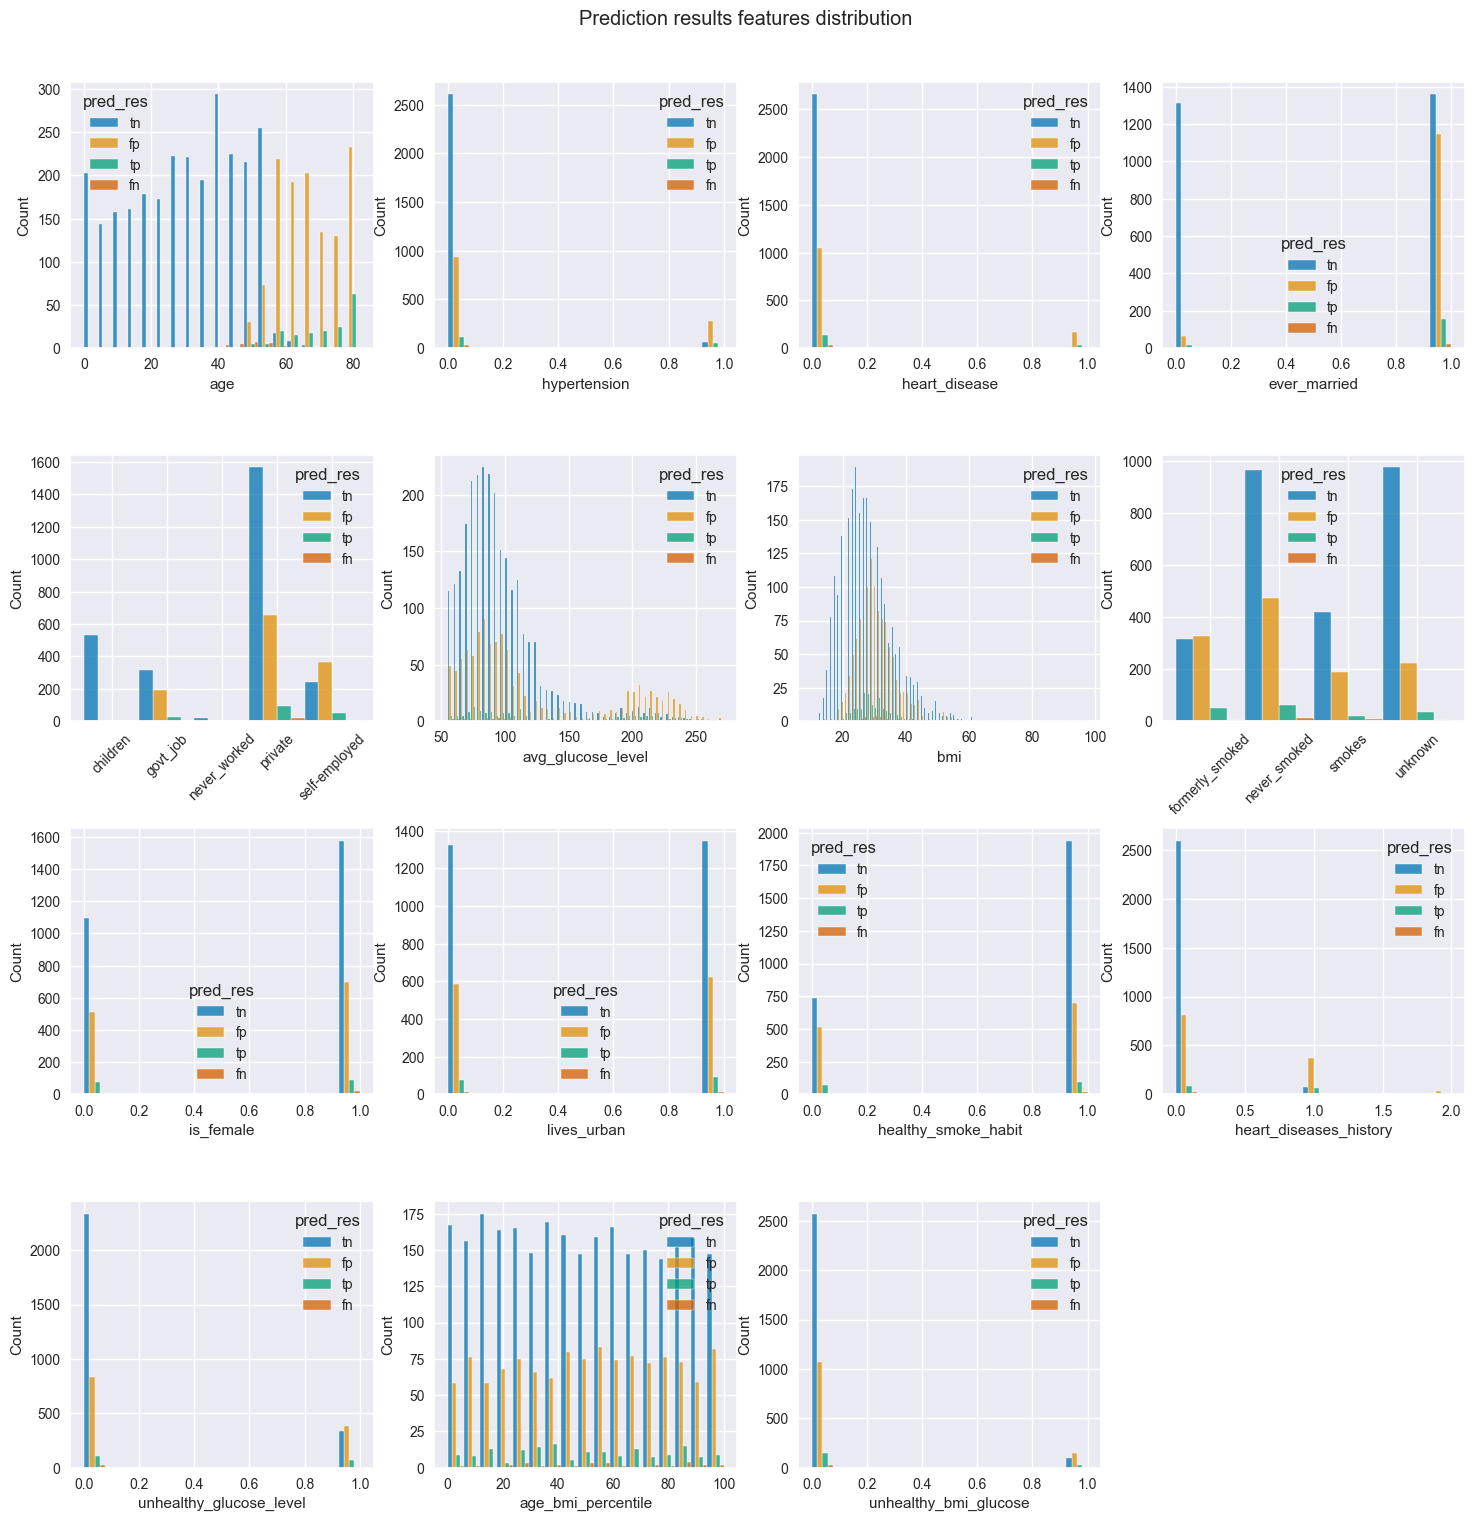

In [16]:
pred_res_plot = pred_df.copy()
pred_res_plot["fn"] = pred_res_plot.fn.apply(
    lambda i: "fn" if i == 1 else False)
pred_res_plot["fp"] = pred_res_plot.fp.apply(
    lambda i: "fp" if i == 1 else False)
pred_res_plot["tn"] = pred_res_plot.tn.apply(
    lambda i: "tn" if i == 1 else False)
pred_res_plot["tp"] = pred_res_plot.tp.apply(
    lambda i: "tp" if i == 1 else False)

res_ls = []
for i in range(pred_res_plot.shape[0]):
    val = (
        pred_res_plot.fn[i]
        or pred_res_plot.fp[i]
        or pred_res_plot.tn[i]
        or pred_res_plot.tp[i]
    )
    res_ls.append(val)
pred_res_plot["pred_res"] = res_ls

num_cols = fn_df.select_dtypes(["float", "int"])
n = 1
fig_size(18, 18)
for i in pred_res_plot.iloc[:, :-7].columns:
    plt.subplot(4, 4, n)
    sns.histplot(
        data=pred_res_plot, x=i, multiple="dodge", hue="pred_res", palette="colorblind"
    )
    if n in [5, 8]:
        plt.xticks(rotation=45)
        plt.xlabel("")
    n += 1
plt.suptitle("Prediction results features distribution", y=0.92)
plt.subplots_adjust(hspace=0.4)
plt.show()

<!-- 📝 Full data:

Common criterion for classifying instances to class 1 (stroke)
- `Older`: age > 45 
- `Ever married`: ever_married = True
- `Higher glucose level`: avg_glucose_level > 140, healthy_glucose_level = 0
- `Higher bmi`: bmi, age_bmi_percentile (not linear, but trend can be observed)
- `Had heart diseases history`: heart_disease_history > 1
- `Smokes/ had smoked`: healthy_smoke_habit = 0
- `Lives urban`: lives_urban = 1 -->

📝 False Negative and False Positive Instances

`FN`:
- Age between age 40 ~60, is the age where FN is distributed
- Other fn instances have characters such as healthy smoke habit, healthy \
glucose... resembles healthy individuals (TN group)

`FP`:
- FP individuals are mostly older than 45 year-old (before 45, there's very \
little stroke occurences in this dataset.)
- They mostly have the unhealthy characteristics (heart diseases/ high glucose/ smokes)

📕 Modeling conclusion

- Age plays the most important role for stroke detection in this dataset, \
as the instances with stroke almost only occurs in elder people, it is hard for \
all models to identify stroke precisely in the elderly group, thus almost 1/3 \
of data is falsely classified as having stroke.

- If we want to do a better job classifying the elderly with/ without stroke, \
we need to have more features, as the existing features cannot help the models to \
distinguish stroke from non-stroke in the elderly group.

- Most models can identify around 85% of stroke patients. 

- Logit and LGBM have the best performance, Logit model requires a smaller sample \
size to perform well (logit: 1000~, LGBM: 1700~), while LGBM has slightly lower \
FP rate (3%).

📊 Test the models

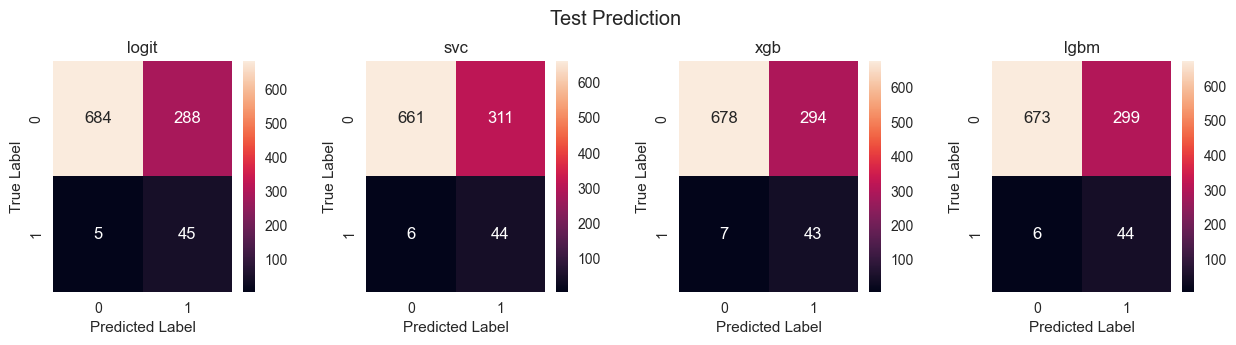

In [17]:
logit_true = best_logit.predict(X_test)
svc_true = best_svc.predict(X_test)
xgb_true = best_xgb.predict(X_test)
lgbm_true = very_best_lgbm.predict(X_test)

fig_size(15, 3)
plt.subplot(1, 4, 1)
plot_confusion(logit_true, y_test, "logit")
plt.subplot(1, 4, 2)
plot_confusion(svc_true, y_test, "svc")
plt.subplot(1, 4, 3)
plot_confusion(xgb_true, y_test, "xgb")
plt.subplot(1, 4, 4)
plot_confusion(lgbm_true, y_test, "lgbm")

plt.subplots_adjust(wspace=0.4)
plt.suptitle(
    "Test Prediction",
    y=1.05,
)

plt.show()

📝 Final test result

Logit model is the clear winner here, with the best true positive and \
true negative rate !

All the models have almost 90% of the positive stroke class correctly classified, \
the differences are not very big.

> Logit model would be deployed 🚀🚀

In [18]:
# save the best model
joblib.dump(best_logit, "./best_model.pkl")
joblib.dump(best_logit, "./stroke_prediction_app/best_model.pkl")

['./stroke_prediction_app/best_model.pkl']